In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We work on the 2D dataset with size 28x28

In [ ]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

In [7]:
# visualization

train_dataset.montage(length=1)



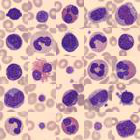

In [8]:

train_dataset.montage(length=5)

In [12]:
    #Access a single image / label
    image, label = train_dataset[2]  # image is a tensor , label is an  int
    print("Shape da imagem:", image.shape)
    print("Classe:", label)
    
    # Convert to NumPy array
    image_array = image.numpy()
    print("Size:", image_array.shape )
    
    #Access a subset of images
    img = train_dataset[1][0].numpy   # image
    lab = train_dataset[1][1]   # label
    start_idx = 10
    end_idx = 20  # exclusive
    images_array = np.stack([train_dataset[i][0].numpy() for i in range(start_idx, end_idx)])
    labels_array = np.array([train_dataset[i][1] for i in range(start_idx, end_idx)])
    
    print("Size:", images_array.shape )
    print(labels_array)




Shape da imagem: torch.Size([3, 28, 28])
Classe: [6]
Size: (3, 28, 28)
Size: (10, 3, 28, 28)
[[1]
 [1]
 [6]
 [7]
 [6]
 [3]
 [7]
 [2]
 [6]
 [1]]
